In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 12.2 넘파이처럼 텐서플로 사용하기
## 12.2.1 텐서와 연산

- tf.constant()함수로 텐서를 만들 수 있다

In [2]:
tf.constant([[1.,2.,3.],[4.,5.,6.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1.,2.,3.],[4.,5.,6.]])
t.shape

TensorShape([2, 3])

In [5]:
t[:,1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

## 12.2.2 텐서와 넘파이
- 넘파이 배열로 텐서를 만들 수 있고, 그 반대도 가능
- 넘파이 연산을 텐서에 적용할 수도, 그 반대도 가능

In [6]:
a = np.array([2.,4.,5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [7]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [8]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [9]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

## 12.2.3 타입변환
- 타입이 자동으로 변환되면 사용자가 눈치채지 못한채로 성능이 감소될 수 있다.
- 따라서 텐서플로는 타입변환을 자동으로 수행하지 않음

In [10]:
tf.constant(2.) + tf.cast(tf.constant(40., dtype=tf.float64), tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

# 12.3 사용자 정의모델과 훈련알고리즘
12.3 사용자 정의모델과 훈련알고리즘
## 12.3.1 사용자 정의 손실함수

In [11]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1,1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

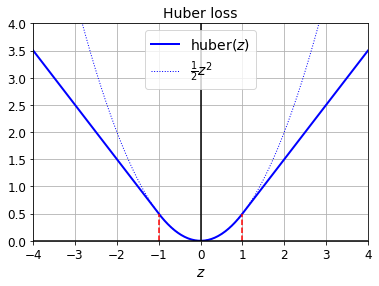

In [13]:
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [14]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1)
])

In [15]:
model.compile(loss=huber_fn, optimizer="nadam", metrics="mae")

In [16]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 992us/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 0s 755us/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


In [17]:
model.save("my_model_with_a_custom_loss.h5")

In [18]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5", custom_objects={"huber_fn":huber_fn})

In [19]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 923us/step - loss: 0.2054 - mean_absolute_error: 0.4982 - val_loss: 0.2209 - val_mean_absolute_error: 0.5050
Epoch 2/2
363/363 [==============================] - 0s 755us/step - loss: 0.1999 - mean_absolute_error: 0.4900 - val_loss: 0.2127 - val_mean_absolute_error: 0.4986


In [20]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [21]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 975us/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 0s 793us/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


모델을 저장할때 threshold 값은 저장되지 않는다   
따라서 함수를 정의할때 threshold를 지정할 수 있도록 정의해야하고, 모델을 로드할떄도 threshold를 지정해야한다

In [22]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [23]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5", custom_objects={"huber_fn":create_huber(2.0)})

In [24]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 964us/step - loss: 0.2147 - mean_absolute_error: 0.4800 - val_loss: 0.2133 - val_mean_absolute_error: 0.4654
Epoch 2/2
363/363 [==============================] - 0s 802us/step - loss: 0.2119 - mean_absolute_error: 0.4762 - val_loss: 0.1992 - val_mean_absolute_error: 0.4643


keras.losses.loss 클래스를 상속하여 get_config()메서드를 구현하여 해결가능

In [25]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold":self.threshold}

In [26]:

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [27]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [28]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 932us/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 0s 807us/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [29]:
model.save("my_model_with_a_custom_loss_class.h5")

In [30]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 829us/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 0s 771us/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [31]:
model.loss.threshold

2.0

활성화함수, 초기화, 규제, 제한을 커스터마이징하기

In [32]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2./shape[0]+shape[1])
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
    return tf.where(weights <0., tf.zeros_like(weights), weights)

In [34]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [35]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [36]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 912us/step - loss: 2.3482 - mae: 0.8713 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 730us/step - loss: 1.1179 - mae: 0.5660 - val_loss: inf - val_mae: inf


In [37]:
model.save("my_model_with_many_custom_parts.h5")

In [38]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
        "my_l1_regularizer":my_l1_regularizer,
        "my_positive_weights":my_positive_weights,
        "my_glorot_initializer":my_glorot_initializer,
        "my_softplus":my_softplus
    }
)

In [39]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor *weights))
    
    def get_config(self):
        return {"factor":self.factor}

In [40]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])


model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


model.save("my_model_with_many_custom_parts.h5")

Epoch 1/2
363/363 [==============================] - 0s 915us/step - loss: 2.3482 - mae: 0.8713 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 747us/step - loss: 1.1179 - mae: 0.5660 - val_loss: inf - val_mae: inf


In [42]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

스트리밍 지표

In [43]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def huber_fn(self, y_true, y_pred):
        error =y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold" : self.threshold}

In [44]:
m = HuberMetric(2.)

m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [45]:
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [46]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [47]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [48]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)
model.save("my_model_with_a_custom_metric.h5")

Epoch 1/2
363/363 [==============================] - 0s 595us/step - loss: 0.7864 - huber_metric_1: 0.7864
Epoch 2/2
363/363 [==============================] - 0s 568us/step - loss: 0.2497 - huber_metric_1: 0.2497


In [49]:

model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)
model.metrics[-1].threshold


Epoch 1/2
363/363 [==============================] - 0s 571us/step - loss: 0.2328 - huber_metric_1: 0.2328
Epoch 2/2
363/363 [==============================] - 0s 565us/step - loss: 0.2234 - huber_metric_1: 0.2234


2.0

In [50]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

## 12.3.5 사용자 정의층
- 가중치가 없는 층 > keras.layers.Lambda
- 가중치가 있는 층 > keras.layers.Layer 상속

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
exponential_layer = keras.layers.Lambda(lambda x : tf.exp(x))
exponential_layer([-1.,0.,1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [54]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 0s 807us/step - loss: 0.8798 - val_loss: 0.4972
Epoch 2/5
363/363 [==============================] - 0s 670us/step - loss: 0.4639 - val_loss: 0.3846
Epoch 3/5
363/363 [==============================] - 0s 672us/step - loss: 0.4086 - val_loss: 0.3741
Epoch 4/5
363/363 [==============================] - 0s 686us/step - loss: 0.3884 - val_loss: 3650298880.0000
Epoch 5/5
162/162 [==============================] - 0s 426us/step - loss: 0.3706


0.3706350028514862

In [56]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [57]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [58]:

model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [59]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 0s 848us/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 401us/step - loss: 0.5474


0.5473727583885193

In [60]:
model.save("my_model_with_a_custom_layer.h5")

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [62]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]


In [64]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs, outputs = MyMultiLayer()((inputs1, inputs2))

call()메서드에 training 매개변수를 추가해서 훈련인지 테스트인지 결정

In [65]:
class AddGaussainNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
    
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [66]:

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 0s 827us/step - loss: 0.4904 - val_loss: 0.5329
Epoch 2/2
162/162 [==============================] - 0s 420us/step - loss: 0.3990


0.3990039527416229

## 12.3.6 사용자 정의 모델
- keras.Model 클래스를 상속받아 생성자에서 층과 변수 생성
- 모델이 해야할 작업을 call() 메서드에 구현

In [68]:
X_new_scaled = X_test_scaled

In [69]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [70]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1+3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)
        

## 12.3.7 모델 구성요소에 따른 기반한 loss와 metric

In [71]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        # TODO: check https://github.com/tensorflow/tensorflow/issues/26260
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs, name='recon')
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        
        if training:
           result = self.reconstruction_mean(recon_loss)
           self.add_metric(result)
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

In [72]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 0s 796us/step - loss: 0.7885 - reconstruction_error: 0.0000e+00
Epoch 2/2
363/363 [==============================] - 0s 782us/step - loss: 0.4126 - reconstruction_error: 0.0000e+00


## 12.3.8 자동 미분을 사용하여 그래디언트 계산

In [74]:
def f(w1,w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [75]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)

with tf.GradientTape() as tape:
    z = f(w1,w2)

gradients = tape.gradient(z, [w1,w2])

In [76]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

## 12.3.9 사용자 정의 훈련반복

In [79]:

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [80]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [81]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [82]:

n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [83]:

for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 - mean: 1.7296 - mean_absolute_error: 0.6054
Epoch 2/5
11610/11610 - mean: 0.6976 - mean_absolute_error: 0.5293
Epoch 3/5
11610/11610 - mean: 0.6325 - mean_absolute_error: 0.5173
Epoch 4/5
11610/11610 - mean: 0.6405 - mean_absolute_error: 0.5203
Epoch 5/5
11610/11610 - mean: 0.6465 - mean_absolute_error: 0.5251
